In [ ]:
# cài bộ thư viện d2l
!pip install d2l==0.16.5


# Convolutional Neural Networks (LeNet)

Bây giờ ta đã sẵn sàng kết hợp tất cả các công cụ lại với nhau để triển khai mạng nơ-ron tích chập hoàn chỉnh. Trong lần trước, chúng ta đã áp dụng softmax regression và một perceptron đa tầng cho ảnh quần áo trong bộ dữ liệu Fashion-MNIST.

Để tương thích với đầu vào dạng vector một chiều với độ dài cố định của các perceptron đa tầng, đầu tiên ta trải phẳng từng hình ảnh và thu được các vector có chiều dài 784, trước khi xử lý chúng với một chuỗi các tầng kết nối đầy đủ.

Bây giờ đã có các tầng tích chập, ta có thể giữ nguyên ảnh đầu vào ở dạng không gian hai chiều như ảnh gốc và xử lý chúng với một chuỗi các tầng tích chập liên tiếp. Hơn nữa, vì ta đang sử dụng các tầng tích chập, số lượng tham số cần thiết sẽ giảm đi đáng kể.

Trong phần này, chúng tôi sẽ giới thiệu một trong những mạng nơ-ron tích chập được công bố đầu tiên. Ưu điểm của mạng tích chập được minh hoạ lần đầu bởi Yann Lecun (lúc đó đang nghiên cứu tại AT&T Bell Labs) với ứng dụng nhận dạng các số viết tay trong ảnh-LeNet5. Vào những năm 90, các thí nghiệm của các nhà nghiên cứu với LeNet đã đưa ra bằng chứng thuyết phục đầu tiên về tính khả thi của việc huấn luyện mạng nơ-ron tích chập bằng lan truyền ngược. Mô hình của họ đã đạt được kết quả rất tốt (chỉ có Máy Vector Hỗ trợ — SVM tại thời điểm đó là có thể sánh bằng) và đã được đưa vào sử dụng để nhận diện các chữ số khi xử lý tiền gửi trong máy ATM. Một số máy ATM vẫn chạy các đoạn mã mà Yann và đồng nghiệp Leon Bottou đã viết vào những năm 1990!


## LeNet

Có thể coi đơn giản LeNet gồm 2 phần : 

(i) một khối các tầng tích chập

(ii) một khối các tầng kết nối đầy đủ

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
<!-- :label:`img_lenet` -->

Các đơn vị cơ bản trong khối tích chập là một tầng tích chập và một lớp gộp trung bình theo sau (lưu ý rằng gộp cực đại hoạt động tốt hơn, nhưng nó chưa được phát minh vào những năm 90). Tầng tích chập được sử dụng để nhận dạng các mẫu không gian trong ảnh, chẳng hạn như các đường cạnh và các bộ phận của vật thể, lớp gộp trung bình phía sau được dùng để giảm số chiều. Khối tầng tích chập tạo nên từ việc xếp chồng các khối nhỏ gồm hai đơn vị cơ bản này. Mỗi tầng tích chập sử dụng kernel size có kích thước  5×5  và xử lý mỗi đầu ra với một hàm kích hoạt sigmoid (ReLU hiện được biết là hoạt động đáng tin cậy hơn, nhưng chưa được phát minh vào thời điểm đó!). Tầng tích chập đầu tiên có 6 kênh đầu ra và tầng tích chập thứ hai tăng độ sâu kênh hơn nữa lên 16.

Tuy nhiên, cùng với sự gia tăng số lượng kênh này, chiều cao và chiều rộng lại giảm đáng kể. Do đó, việc tăng số lượng kênh đầu ra làm cho kích thước tham số của hai tầng tích chập tương tự nhau. Hai lớp gộp trung bình có kích thước  2×2  và sải bước bằng 2 (điều này có nghĩa là chúng không chồng chéo). Nói cách khác, lớp gộp giảm kích thước của các biểu diễn còn một phần tư kích thước trước khi gộp.

Đầu ra của khối tích chập có kích thước được xác định bằng (kích thước batch, kênh, chiều cao, chiều rộng). Trước khi chuyển đầu ra của khối tích chập sang khối kết nối đầy đủ, ta phải trải phẳng từng mẫu trong minibatch. Nói cách khác, ta biến đổi đầu vào 4D thành đầu vào 2D tương thích với các tầng kết nối đầy đủ: nhắc lại, chiều thứ nhất là chỉ số các mẫu trong minibatch và chiều thứ hai là biểu diễn vector phẳng của mỗi mẫu. Khối tầng kết nối đầy đủ của LeNet có ba tầng kết nối đầy đủ, với số lượng đầu ra lần lượt là 120, 84 và 10. Bởi vì ta đang thực hiện bài toán phân loại, tầng đầu ra 10 chiều tương ứng với số lượng các lớp đầu ra khả thi (10 chữ số từ 0 đến 9).

Để thực sự hiểu những gì diễn ra bên trong LeNet có thể đòi hỏi một chút nỗ lực, tuy nhiên bạn có thể thấy bên dưới đây việc lập trình Lenet bằng thư viện học sâu hiện đại rất đơn giản. Một lần nữa, ta sẽ dựa vào lớp Sequential.




In [2]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(400, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

So với mạng ban đầu, ta đã thay thế kích hoạt Gauss ở tầng cuối cùng bằng một tầng kết nối đầy đủ thông thường mà thường dễ huấn luyện hơn đáng kể. Ngoại trừ điểm đó, mạng này giống với định nghĩa gốc của LeNet5.

Tiếp theo, ta hãy xem một ví dụ dưới đây. Như trong hình, ta đưa vào mạng một mẫu đơn kênh kích thước  28×28  và thực hiện một lượt truyền xuôi qua các tầng và in kích thước đầu ra ở mỗi tầng để hiểu rõ những gì đang xảy ra bên trong.


![Compressed notation for LeNet-5.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lenet-vert.svg?raw=1)
<!-- :label:`img_lenet_vert` -->

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


chú ý rằng, chiều cao và chiều rộng của biểu diễn sau mỗi tầng trong toàn bộ khối tích chập sẽ giảm theo chiều sâu của mạng(so với chiều cao và chiều rộng của biểu diễn ở tầng trước). Tầng tích chập đầu tiên sử dụng một hạt nhân với chiều cao và chiều rộng là  5  rồi đệm thêm  2  đơn vị điểm ảnh để giữ nguyên kích thước đầu vào. Trong khi đó, tầng tích chập thứ hai cũng dùng cùng một hạt nhân với kích thước là  5×5  mà không có sử dụng giá trị đệm thêm vào, dẫn đến việc chiều cao và chiều rộng giảm đi 4 đơn vị điểm ảnh. Ngoài ra, mỗi tầng gộp sẽ làm giảm đi một nửa chiều cao và chiều rộng của đặc trưng ánh xạ đầu vào. Tuy nhiên, khi chúng ta đi theo chiều sâu của mạng, số kênh sẽ tăng lần lượt theo từng tầng. Từ 1 kênh của dữ liệu đầu vào lên tới 6 kênh sau tầng tích chập thứ nhất và 16 kênh sau tầng tích chập thứ hai. Sau đó,giảm số chiều lần lượt qua từng tầng kết nối đầy đủ đến khi trả về một đầu ra có kích thước bằng số lượng lớp của hình ảnh.

## Training

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Dù mạng tích chập có thể có số lượng tham số không lớn, chúng vẫn tiêu tốn nhiều tài nguyên tính toán hơn so với perceptron sâu đa tầng. Vì vậy, nếu có sẵn GPU, thì đây là thời điểm thích hợp để dùng nó nhằm tăng tốc quá trình huấn luyện.

Chúng ta cũng cần phải cập nhật hàm huấn luyện để mô hình có thể chạy được trên GPU. Chúng ta cần chuyển từng batch dữ liệu tới ngữ cảnh được chỉ định (hy vọng là GPU thay vì CPU) trước khi thực hiện lượt truyền xuôi và lượt truyền ngược.

Để đơn giản khi làm việc với mạng nơ-ron có tới hàng chục tầng, hàm train_ch6 chỉ hỗ trợ các mô hình được xây dựng bằng thư viện Gluon. Để khởi tạo bộ tham số của mô hình trên thiết bị đã được chỉ định bởi ctx, ta sẽ sử dụng bộ khởi tạo Xavier. Ta vẫn sử dụng hàm mất mát entropy chéo và thuật toán huấn luyện là phương pháp hạ gradient ngẫu nhiên theo minibatch. Với mỗi epoch tốn khoảng hàng chục giây để chạy, ta sẽ vẽ đường biểu diễn giá trị mất mát huấn luyện với nhiều giá trị chi tiết hơn.

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): # None này có thể để nguyên !
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [6]:
# Không cần thay đổi hàm này nhé bạn
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device) # chuyển model sang device trên
    optimizer = torch.optim.SGD(net.parameters(),lr) # optimizer
    loss = nn.CrossEntropyLoss() # loss f
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad() # zero grad
            X, y = X.to(device) , y.to(device) # which device? 
            y_hat = net(X)
            l = loss(y_hat,y) # loss
            l.backward # backward
            optimizer.step() # update
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net,test_iter) # evaluate model với test_iter
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 2.465, train acc 0.100, test acc 0.100
63909.6 examples/sec on cuda:0


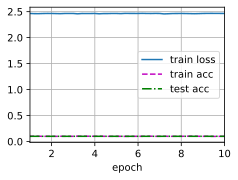

In [8]:
#Bắt đầu traning vói train_ch6
lr, num_epochs = 0.01, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary

* Mạng nơ-ron tích chập (gọi tắt là ConvNet) là một mạng sử dụng các tầng tích chập.

* Trong ConvNet, ta xen kẽ các phép tích chập, các hàm phi tuyến và các phép gộp.

* Độ phân giải được giảm xuống trước khi tạo một đầu ra thông qua một (hoặc nhiều) tầng kết nối dày đặc.

* Trong CNN truyền thống, các biểu diễn được mã hóa bởi các khối tích chập được xử lý bởi một hoặc nhiều lớp FC trước khi output.

* LeNet là mạng ConvNet đầu tiên được triển khai thành công.




[Discussions](https://discuss.d2l.ai/t/275)
